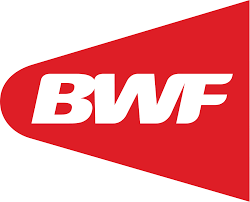

# Investigation into Optimal Badminton Strategy for Men's Singles

I love playing badminton as a sport, especially the strategic aspect of it. I would love to analyse what factors are most important in predicting the outcome of a match and devise optimal badminton strategy.

To do this, I will use dataset of badminton matches across different BWF World Tour competitions from 2018 to 2021, downloaded from kaggle.

Goal:
- Match Win Prediction and most important features
- Point by point and optimal tactic analysis

Areas for future research:
- Individual Player statistics and analysis


Referenced works:
- https://www.kaggle.com/code/juanliong/badminton-scoring-change-analysis
- https://www.kaggle.com/code/blueberry1215/badminton-home-advantage-analysis

In [1]:

# Things to explore:
# Win%
# Streak strategy, etc

# Service impact


In [2]:
# OS and file management

from pathlib import Path
import os

# Data processing and analysis
import pandas as pd
import numpy as np

from fastai import *
from kaggle import api

#Visualisations
import missingno as msno
import plotly.express as px 
import matplotlib as plt


#Options
pd.options.display.max_rows = 10

In [3]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
dataset_path = Path("datasets")
path = Path(os.path.join(Path("datasets"),Path("badminton-bwf-world-tour")))

In [5]:
if not path.exists():
    os.system(f"kaggle datasets download -d sanderp/badminton-bwf-world-tour -p {dataset_path}")
    ZipFile(f'{path}.zip').extractall(path)

In [6]:
os.listdir(path)

['md.csv', 'LICENSE', 'README.md', 'ms.csv', 'ws.csv', 'xd.csv', 'wd.csv']

# EDA and Processing Data

In [7]:
ms = pd.read_csv(str(path) + '/ms.csv')

In [8]:
ms.describe()

,winner,nb_sets,team_one_total_points,team_two_total_points,team_one_most_consecutive_points,team_two_most_consecutive_points,team_one_game_points,team_two_game_points,team_one_most_consecutive_points_game_1,team_two_most_consecutive_points_game_1,team_one_game_points_game_1,team_two_game_points_game_1,team_one_most_consecutive_points_game_2,team_two_most_consecutive_points_game_2,team_one_game_points_game_2,team_two_game_points_game_2,team_one_most_consecutive_points_game_3,team_two_most_consecutive_points_game_3,team_one_game_points_game_3,team_two_game_points_game_3
count,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3761.000000,3723.000000,3723.000000,3723.000000,3723.000000,1302.000000,1302.000000,1302.000000,1302.000000
mean,1.459718,2.339271,41.928476,41.612603,5.665249,5.624568,2.193034,2.086413,4.460516,4.437650,0.962776,0.896570,4.483212,4.405050,0.912168,0.879936,4.570661,4.533794,0.945469,0.920891
std,0.534488,0.493869,12.294976,12.452383,2.155618,2.234039,1.986514,1.946418,1.805016,1.864965,1.205571,1.173144,1.909400,1.931329,1.149291,1.133882,1.880152,1.921602,1.196050,1.206201
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,2.000000,33.000000,32.000000,4.000000,4.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000
50%,1.000000,2.000000,42.000000,42.000000,5.000000,5.000000,2.000000,2.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,1.000000,1.000000
75%,2.000000,3.000000,52.000000,52.000000,7.000000,7.000000,3.000000,3.000000,5.000000,5.000000,2.000000,1.000000,5.000000,5.000000,1.000000,1.000000,5.750000,5.000000,1.000000,1.000000
max,2.000000,3.000000,71.000000,69.000000,21.000000,19.000000,11.000000,12.000000,16.000000,15.000000,9.000000,9.000000,18.000000,19.000000,9.000000,9.000000,16.000000,16.000000,8.000000,9.000000


### Cleaning

1. Identifying missing values

<Axes: >

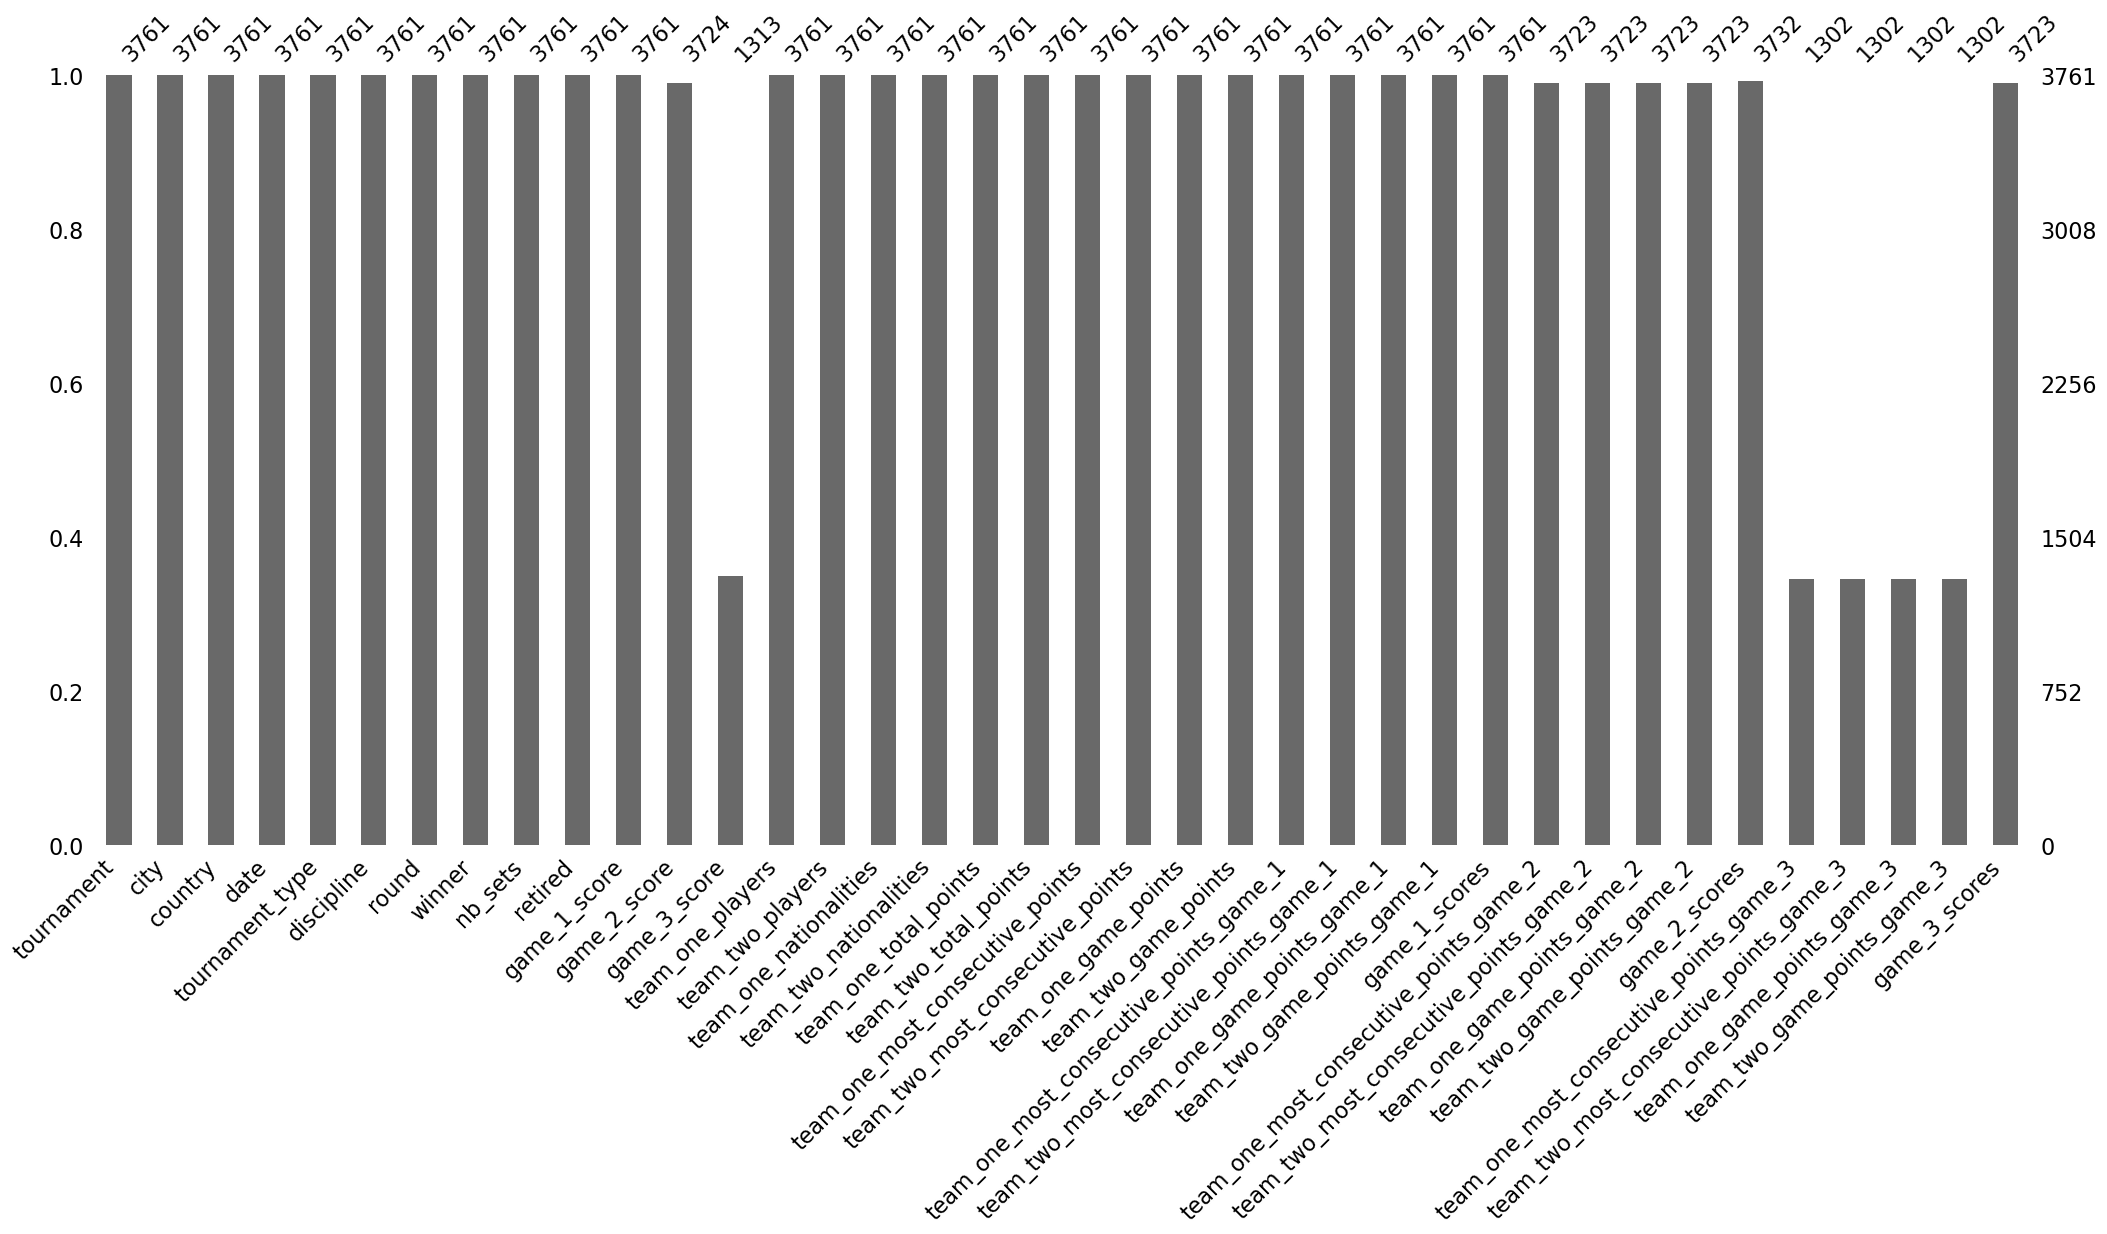

In [9]:
msno.bar(ms)

<Axes: >

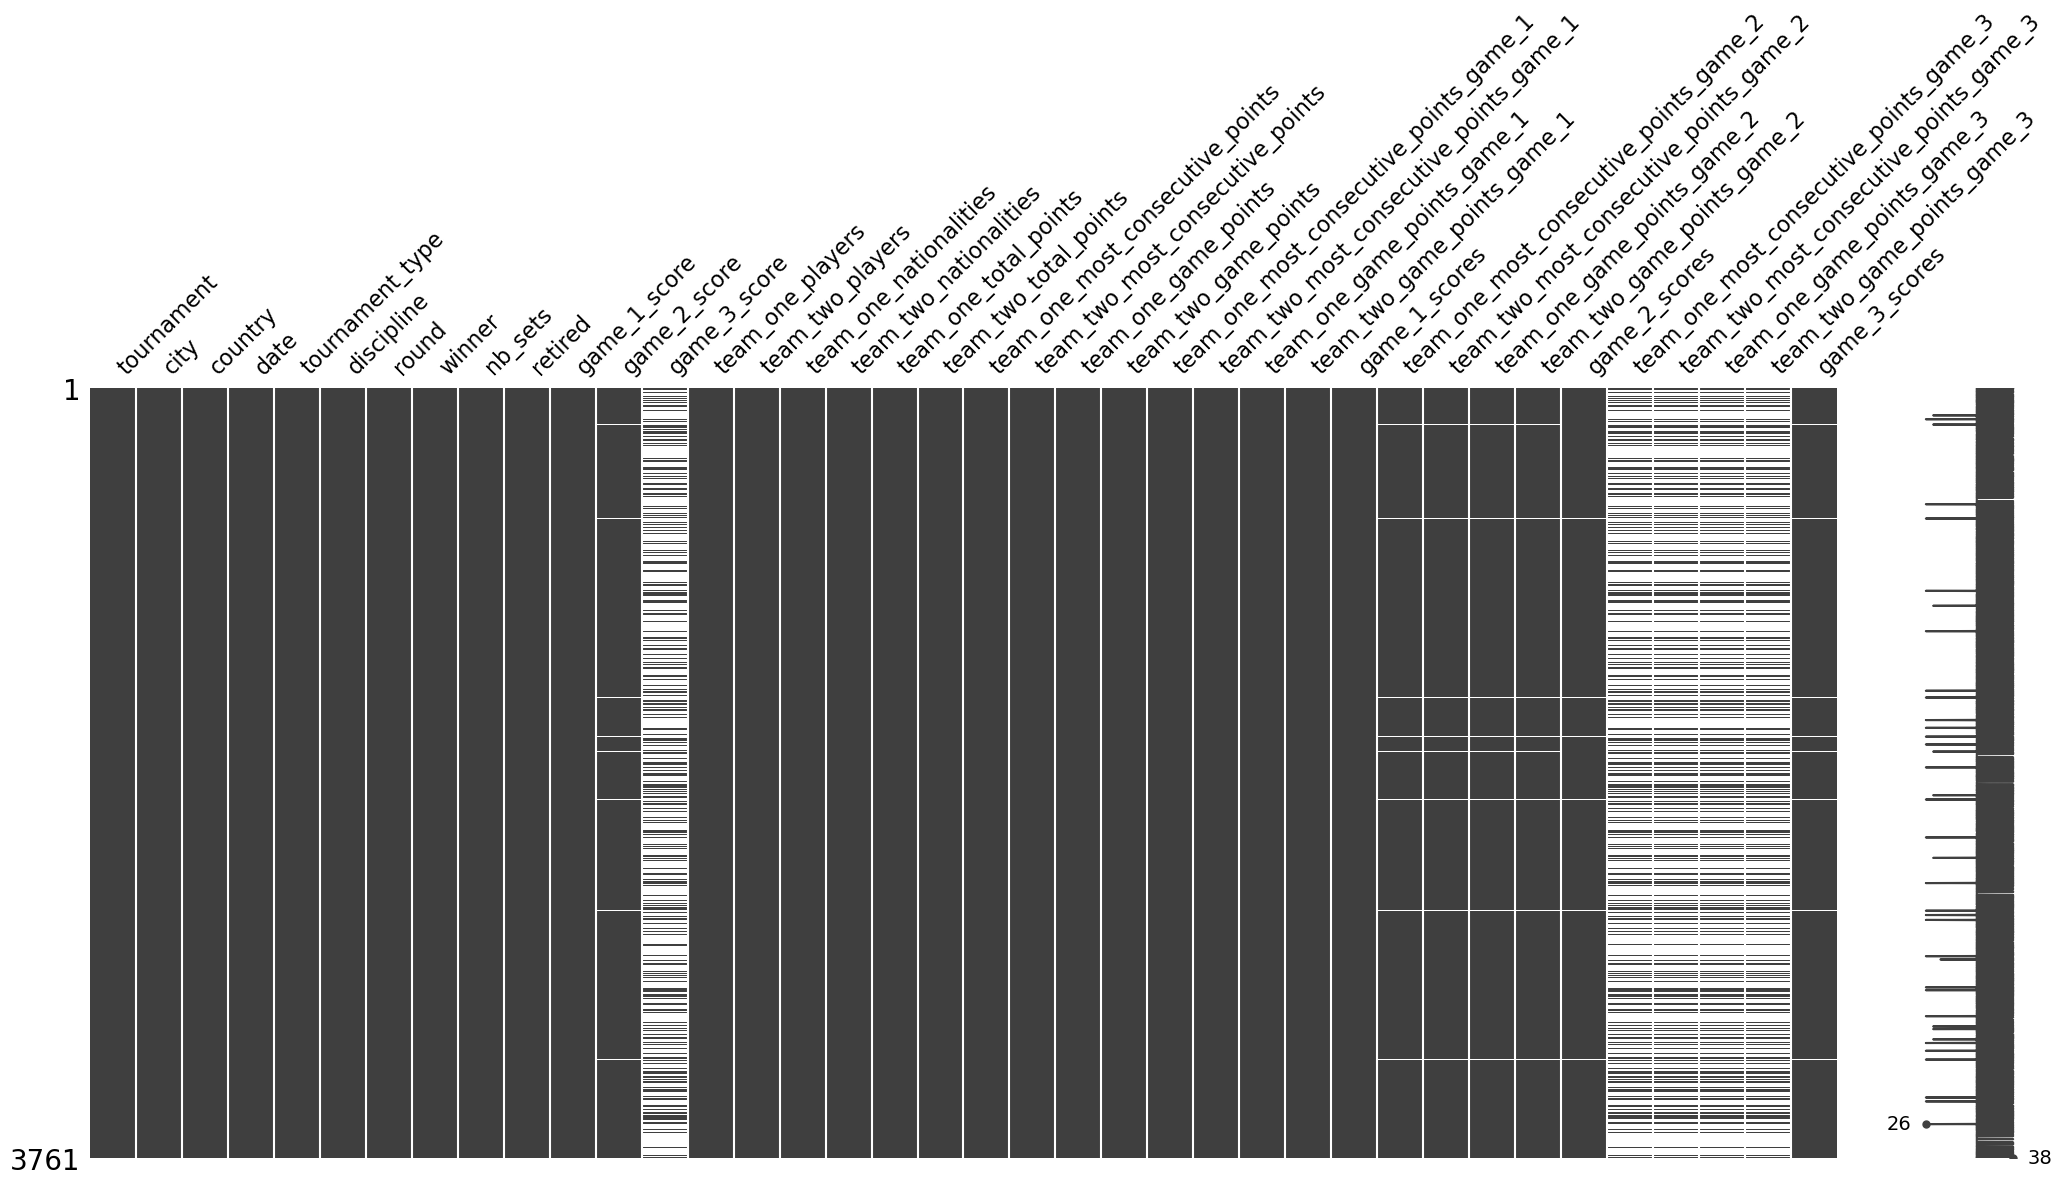

In [10]:
msno.matrix(ms)

We see that a bunch of games are incomplete, due to retirements. Also row number 28 is missing values, so we will drop those as well.

2. Filtering out retirements and incomplete games

Removing the total point count, because that would be an accurate predictor of match outcomes

In [11]:
drop_colmumns = ['country','team_one_total_points','team_two_total_points']

In [12]:
def filter_incomplete(df):
    '''
    Filter out incomplete games. 
    '''
    df = df.copy()
    df = df[df.retired == False]
    df.reset_index(inplace = True)
    df.drop(columns = 'index', inplace = True)
    return df

In [13]:
ms = filter_incomplete(ms)

<Axes: >

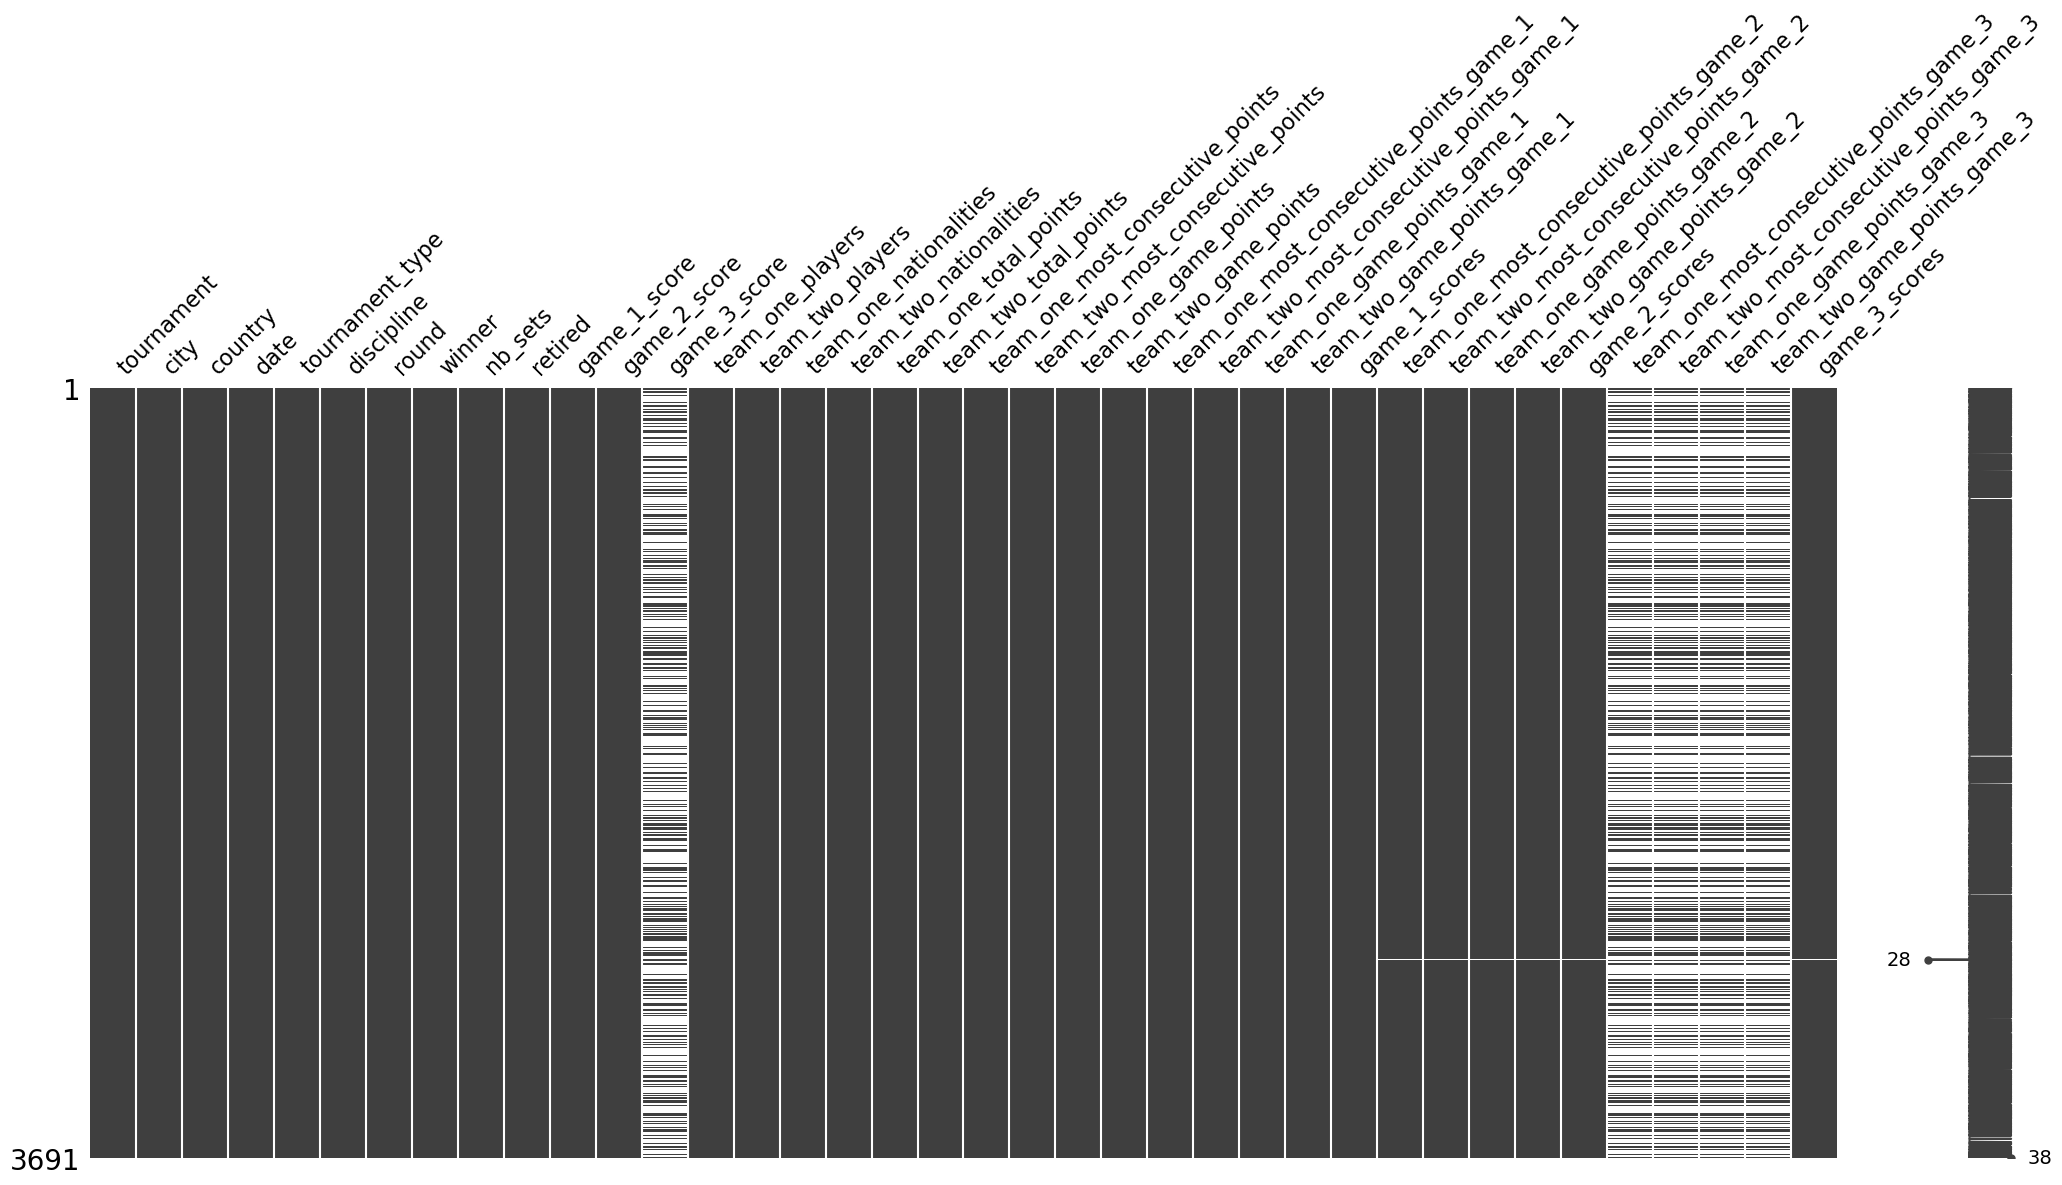

In [14]:
msno.matrix(ms)

## Predicting Winner of Game Three

First, we remove all entries that do not have a game 3

In [15]:
def filter_game_three(df):
    '''
    Filter out entires that dont contain game 3
    '''
    df = df.copy()
    df = df[df['nb_sets'] == 3]
    df.drop(2739, inplace = True) # Dropping this entry due to NaN values
    df.reset_index(inplace = True)
    df.drop(columns = 'index', inplace = True)
    return df

In [16]:
ms = filter_game_three(ms)

<Axes: >

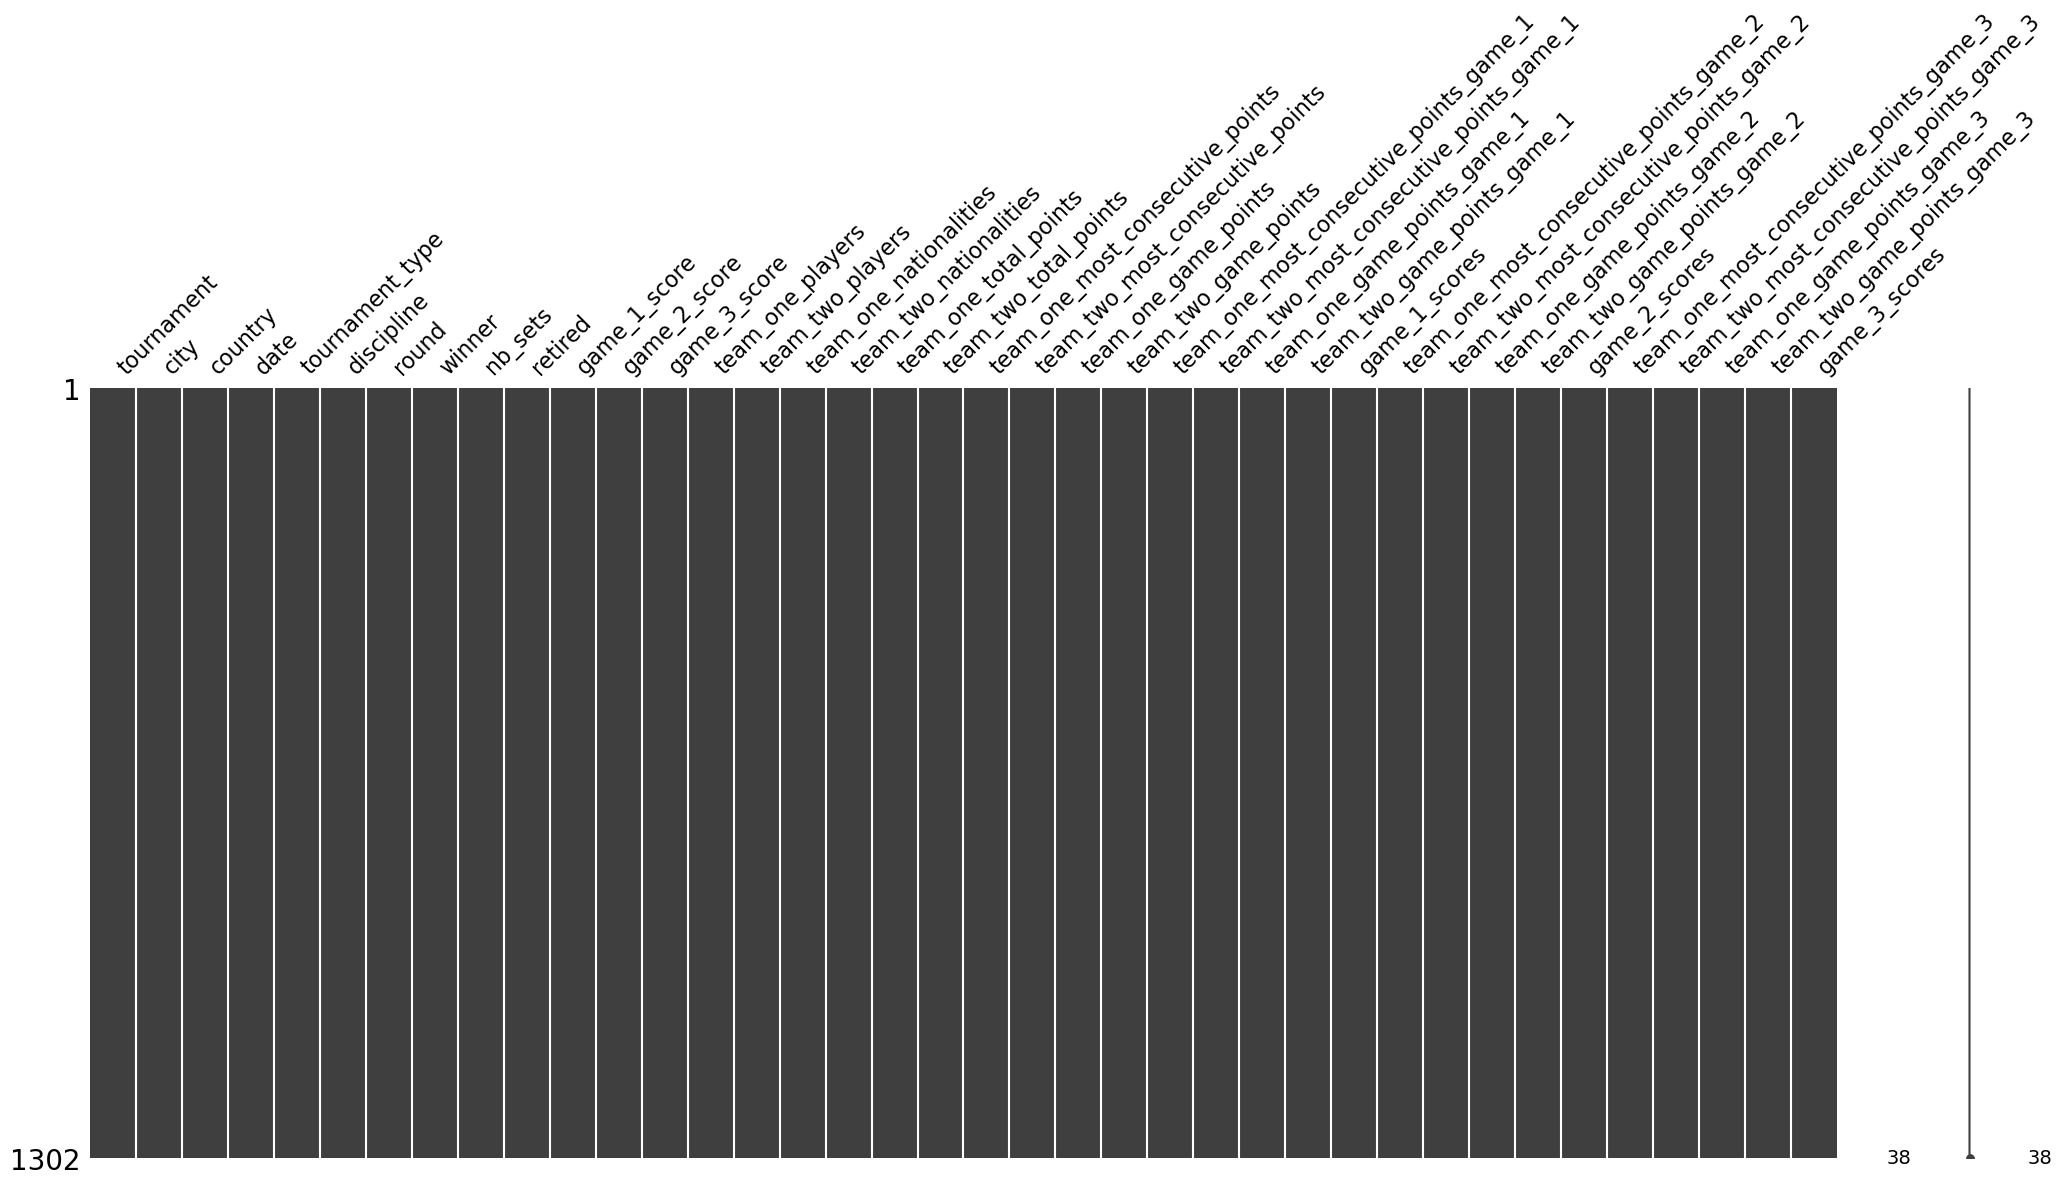

In [17]:
msno.matrix(ms)

In [18]:
na_df = ms[ms.isna().any(axis=1)]
na_df
# No rows without information

,tournament,city,country,date,tournament_type,discipline,round,winner,nb_sets,retired,...,team_one_most_consecutive_points_game_2,team_two_most_consecutive_points_game_2,team_one_game_points_game_2,team_two_game_points_game_2,game_2_scores,team_one_most_consecutive_points_game_3,team_two_most_consecutive_points_game_3,team_one_game_points_game_3,team_two_game_points_game_3,game_3_scores


Now we have to remove all information that cannot be known before game 3.

In [19]:
ms.columns

Index(['tournament', 'city', 'country', 'date', 'tournament_type',
       'discipline', 'round', 'winner', 'nb_sets', 'retired', 'game_1_score',
       'game_2_score', 'game_3_score', 'team_one_players', 'team_two_players',
       'team_one_nationalities', 'team_two_nationalities',
       'team_one_total_points', 'team_two_total_points',
       'team_one_most_consecutive_points', 'team_two_most_consecutive_points',
       'team_one_game_points', 'team_two_game_points',
       'team_one_most_consecutive_points_game_1',
       'team_two_most_consecutive_points_game_1',
       'team_one_game_points_game_1', 'team_two_game_points_game_1',
       'game_1_scores', 'team_one_most_consecutive_points_game_2',
       'team_two_most_consecutive_points_game_2',
       'team_one_game_points_game_2', 'team_two_game_points_game_2',
       'game_2_scores', 'team_one_most_consecutive_points_game_3',
       'team_two_most_consecutive_points_game_3',
       'team_one_game_points_game_3', 'team_two_game_p

In [20]:
to_drop = ['discipline','retired', 'game_3_score','team_one_most_consecutive_points_game_3',
       'team_two_most_consecutive_points_game_3',
       'team_one_game_points_game_3', 'team_two_game_points_game_3',
       'game_3_scores']

In [21]:
ms = ms.drop(columns = to_drop)

In [22]:
ms.columns

Index(['tournament', 'city', 'country', 'date', 'tournament_type', 'round',
       'winner', 'nb_sets', 'game_1_score', 'game_2_score', 'team_one_players',
       'team_two_players', 'team_one_nationalities', 'team_two_nationalities',
       'team_one_total_points', 'team_two_total_points',
       'team_one_most_consecutive_points', 'team_two_most_consecutive_points',
       'team_one_game_points', 'team_two_game_points',
       'team_one_most_consecutive_points_game_1',
       'team_two_most_consecutive_points_game_1',
       'team_one_game_points_game_1', 'team_two_game_points_game_1',
       'game_1_scores', 'team_one_most_consecutive_points_game_2',
       'team_two_most_consecutive_points_game_2',
       'team_one_game_points_game_2', 'team_two_game_points_game_2',
       'game_2_scores'],
      dtype='object')

In [25]:
ms.iloc[1]['game_1_scores']

"['0-0', '1-0', '2-0', '2-1', '3-1', '4-1', '5-1', '6-1', '6-2', '7-2', '8-2', '9-2', '9-3', '9-4', '10-4', '11-4', '12-4', '13-4', '13-5', '13-6', '13-7', '13-8', '14-8', '15-8', '15-9', '16-9', '16-10', '16-11', '16-12', '16-13', '17-13', '17-14', '17-15', '18-15', '19-15', '20-15', '20-16', '21-16']"

In [ ]:
ms.info()

numeric_columns = ['round', 'game_1_score', 'game_2_score', 'game_1_scores', 'game_2_scores']
